This notebook gives an example of how to extract energies and observables from the data saved to `.npy` files during an excited states calculation, as described in ["Natural Quantum Monte Carlo Calculation of Excited States"](https://arxiv.org/abs/2308.16848), especially Section IIB and Appendix C. Note that density matrix results will be saved to a `.npy` file even for a ground state calculation, while spin magnitude and dipole moment will be logged directly to `results.csv`. For an excited states calculation, only the total spin magnitude and dipole moments will be logged to `results.csv`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Generate example results of excited state energy and observables

Note that this is just synthetic data in the same format as that generated by the actual training and inference code. It is provided here purely to have something to input to the analysis code without having to run the training code.

In [ ]:
t = 10_000  # number of steps
k = 4  # number of excited states
m = 5  # number of electrons
eps = 1e-2  # noise level
noisy = lambda x: x + eps * np.random.randn(*x.shape)

energy = np.sort(np.random.randn(k) - 10)  # energies of each state
energy_mat = np.diag(energy)

s2 = np.zeros((k, k))  # spin magnitude of each state
# first and third excited state is triplet
s2[1, 1] = 2.0
s2[3, 3] = 2.0

# dipole moments, including transition dipole moments
dipole = np.zeros((3, k, k))
dipole[:, 1, 1] = np.random.randn(3)  # first excited state is polar
dipole[:, 0, 2] = np.random.randn(3)  # ground to second excited state is bright
dipole[:, 2, 0] = dipole[:, 0, 2]  # transition dipole moments are symmetric

# one-electron reduced density matrix
nbasis = 10  # number of elements of the basis set
density_matrix = np.zeros((2, nbasis, nbasis, k, k))  # first dimension is alpha/beta spin
for i in range(k):
  density_matrix[:, :m, :m, i, i] = np.eye(m)  # occupy first 5 orbitals to start

# first state: promote highest alpha electron into lowest unoccupied orbital
density_matrix[0, m-1, m-1, 1, 1] = 0
density_matrix[0, m, m, 1, 1] = 1

# second state: promote highest beta electron into lowest unoccupied orbital
density_matrix[1, m-1, m-1, 2, 2] = 0
density_matrix[1, m, m, 2, 2] = 1

# third state: double excitation of both alpha and beta electron
density_matrix[0, m-1, m-1, 3, 3] = 0
density_matrix[0, m, m, 3, 3] = 1

density_matrix[1, m-1, m-1, 3, 3] = 0
density_matrix[1, m, m, 3, 3] = 1

# mix the states together randomly
mix = np.random.randn(k, k)

energy_mat = mix @ energy_mat @ np.linalg.inv(mix)
s2_mat = mix @ s2 @ np.linalg.inv(mix)
dipole_mat = mix @ dipole @ np.linalg.inv(mix)
density_mat = mix @ density_matrix @ np.linalg.inv(mix)

# write files locally, appending after each iteration
with (open("energy_matrix.npy", "ab") as energy_file,
      open("s2_matrix.npy", "ab") as s2_file,
      open("dipole_matrix.npy", "ab") as dipole_file,
      open("density_matrix.npy", "ab") as density_file):
  for _ in tqdm(range(t)):
    np.save(energy_file, noisy(energy_mat))
    np.save(s2_file, noisy(s2_mat))
    np.save(dipole_file, noisy(dipole_mat))
    np.save(density_file, noisy(density_mat))

# Utility functions for loading and analyzing data

In [ ]:
def second_mom(x):
  """Take the outer product along the last two dimensions."""
  shape = x.shape
  x = x.reshape(*shape[:-2], shape[-2] * shape[-1])
  return x[..., :, None] * x[..., None, :]


def diag(x):
  """Take diagonal along last two axes."""
  assert x.shape[-1] == x.shape[-2]
  y = np.zeros(x.shape[:-1])
  for i in range(x.shape[-1]):
    y[..., i] = x[..., i, i]
  return y


def load_data(fname, tail=0):
  """Load the arrays from a file and take the average and variance.

  Args:
    fname: Name of file to load.
    tail: If 0, load all arrays in the file. If n !=0, load the last n arrays.

  Returns:
    Average value of the arrays in the file and the variance.
  """
  with open(fname, "rb") as f:
    fsize = os.fstat(f.fileno()).st_size
    data = np.load(f)
    var_data = second_mom(data)
    arr_size = f.tell()
    fsize -= fsize % arr_size  # cut off any half-saved data
    if tail:
      n = tail
      f.seek(fsize - (tail + 1) * arr_size)
      data = np.load(f)
      var_data = second_mom(data)
    else:
      n = fsize // arr_size
    for _ in tqdm(range(n-1)):
      out = np.load(f)
      data += out
      var_data += second_mom(out)
  mean_data = data / n
  return mean_data, var_data / n ** 2 - second_mom(mean_data) / n  # divide by n an extra time because variance goes down as 1/n with sample size


def get_demixed_std(matrix_and_var, demix):
  """Get the standard deviation per variable from the raw covariance."""
  mat, var = matrix_and_var
  vv = np.kron(np.linalg.inv(demix), demix.T)
  cov_demixed = vv @ var @ vv.T
  var_demixed = diag(cov_demixed).reshape(*mat.shape)
  return np.sqrt(var_demixed)


def get_results(energy_matrix_and_var, *observable_matrices_and_var):
  """Given energy matrix and observable matrices, demix the states and compute the std deviations."""
  energy_mat, energy_var = energy_matrix_and_var
  energy, demix = np.linalg.eig(energy_mat)
  demix = demix[:, np.argsort(energy)]
  energy = np.sort(energy)
  energy_std = get_demixed_std(energy_matrix_and_var, demix)
  observables = [np.linalg.inv(demix) @ mv[0] @ demix for mv in observable_matrices_and_var]
  observable_std = [get_demixed_std(mv, demix) for mv in observable_matrices_and_var]
  return energy, energy_std, observables, observable_std

# Example analysis on synthetic data

## Load and process data

In [ ]:
energy_mat_and_var = load_data("energy_matrix.npy", tail=1000)
s2_mat_and_var = load_data("s2_matrix.npy", tail=1000)
dipole_mat_and_var = load_data("dipole_matrix.npy", tail=1000)
density_mat_and_var = load_data("density_matrix.npy", tail=1000)

In [ ]:
energy_est, energy_std, observables, observable_std = get_results(energy_mat_and_var,
                                                                  s2_mat_and_var,
                                                                  dipole_mat_and_var,
                                                                  density_mat_and_var)

## Recover energy

In [ ]:
energy

array([-11.36837021, -10.57426469, -10.1355083 ,  -9.21913541])

In [ ]:
energy_est

array([-11.36912937, -10.57432248, -10.13547698,  -9.21882609])

In [ ]:
# check if the recovered energy is within two standard deviations of the estimated energy
np.all(np.abs(energy - energy_est) < 2 * np.diag(energy_std))

True

## Recover spin magnitude $\langle S^2 \rangle$

We should recover a diagonal matrix with nonzero entries in the second and fourth position, which indicates alternating singlet and triplet states.

Text(0.5, 1.0, 'Estimated')

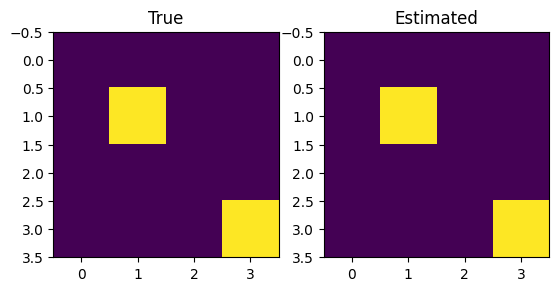

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(s2)
ax[0].set_title('True')

ax[1].imshow(observables[0])
ax[1].set_title('Estimated')

## Compute oscillator strength from transition dipole moment

Without multiplication by the transpose, the off-diagonal elements will be wrong

Text(0.5, 1.0, 'Estimated')

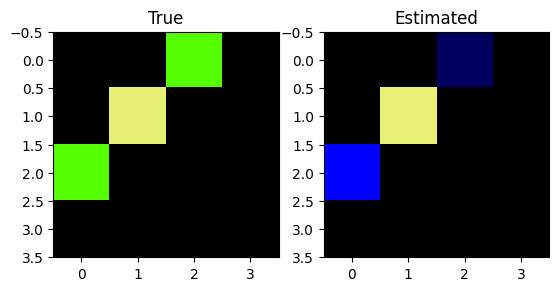

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(dipole.transpose((1, 2, 0)))
ax[0].set_title('True')

ax[1].imshow(observables[1].transpose((1, 2, 0)))
ax[1].set_title('Estimated')

Multiplying elementwise by the transpose allows us to recover off-diagonal terms up to a sign

Text(0.5, 1.0, 'Estimated')

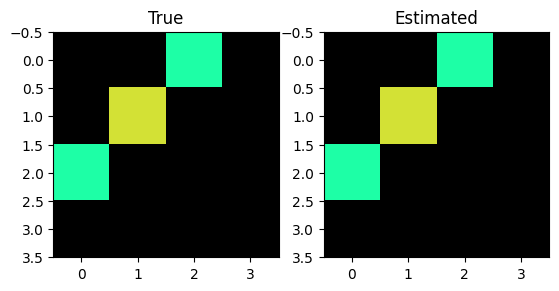

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(dipole.transpose((1, 2, 0)) * dipole.transpose((2, 1, 0)))
ax[0].set_title('True')

ax[1].imshow(observables[1].transpose((1, 2, 0)) * observables[1].transpose((2, 1, 0)))
ax[1].set_title('Estimated')

This can then be directly converted into oscillator strengths

In [ ]:
f = 2/3 * (energy_est[:, None] - energy_est[None, :]) * np.sum(dipole.transpose((1, 2, 0)) * dipole.transpose((2, 1, 0)), axis=-1)

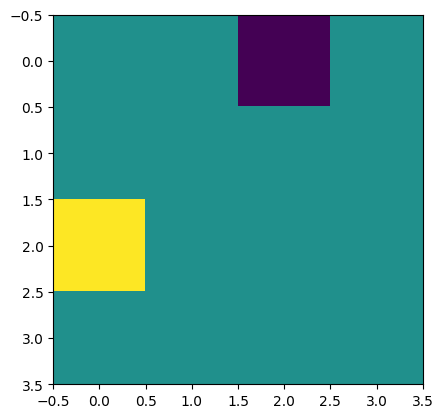

In [ ]:
plt.imshow(f)  # the only bright transition is from the ground state to 2nd excited state

## Visualize one-electron reduced density matrix

True value. Top row is alpha electrons, bottom row is beta electrons. X and Y axes in a real calculation would index different basis set elements created by PySCF.

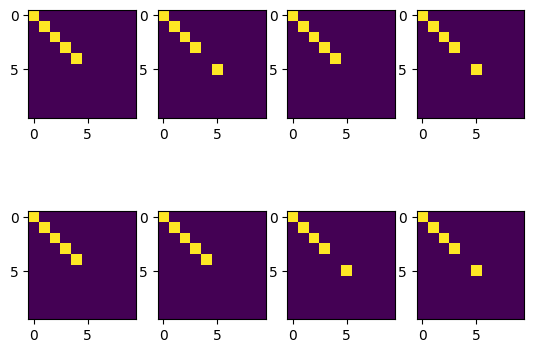

In [ ]:
fig, ax = plt.subplots(2, k)

for i in range(2):
  for j in range(k):
    ax[i, j].imshow(density_matrix[i, :, :, j, j])

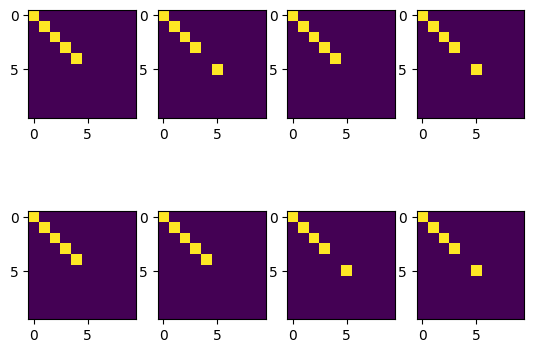

In [ ]:
fig, ax = plt.subplots(2, k)

for i in range(2):
  for j in range(k):
    ax[i, j].imshow(observables[2][i, :, :, j, j])

The occupancy of different orbitals can be clearly seen along the diagonal. In this case we assume that the natural orbitals closely match the chosen basis. If the recovered density matrices are not diagonal, then the matrices can be diagonalized to recover the *natural* orbitals.